## Sample analysis

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io.wavfile
import matplotlib.pyplot as plt

from eggd800.signal import butter_lowpass_filter
from audiolabel import read_label
from phonlab.utils import dir2df, match_tokentimes

In [2]:
datadir = Path(
    '/Users/ronald/src/amznas/doc/'
)

Get dataframes of textgrids and .wav files to analyze. I'm working with a single made up textgrid. Extract experiment variables from the filenames.

In [3]:
tgdf = dir2df(
    datadir,
    fnpat='(?P<lang>[^_]+)_(?P<spkr>[^_]+)_(?P<researcher>[^_]+)_(?P<tstamp>[^_]+)_(?P<item>.+)_(?P<rep>\d+)\.TextGrid',
    addcols=['barename']
)   
tgdf

,relpath,fname,barename,lang,spkr,researcher,tstamp,item,rep
0,.,pid_aop_jrl_20220512T090852__matarM__0.TextGrid,pid_aop_jrl_20220512T090852__matarM__0,pid,aop,jrl,20220512T090852,_matarM_,0


In [4]:
wavdf = dir2df(
    datadir,
    fnpat='(?P<lang>[^_]+)_(?P<spkr>[^_]+)_(?P<researcher>[^_]+)_(?P<tstamp>[^_]+)_(?P<item>.+)_(?P<rep>\d+)\.wav',
    addcols=['barename']
)
wavdf

,relpath,fname,barename,lang,spkr,researcher,tstamp,item,rep
0,.,pid_aop_jrl_20220512T090852__matarM__0.wav,pid_aop_jrl_20220512T090852__matarM__0,pid,aop,jrl,20220512T090852,_matarM_,0


In [5]:
def get_sigs(wavfile, chan=['audio', 'orfl', None, 'nsfl'], cutoff=50, order=3):
    '''
    Get signals from `wavfile`.
    
    Parameters
    ----------
    
    wavfile : Path or str
    The .wav file to read.
    
    chan : list of str
    A list of signal channels in the order that they occur in the wavfile. Use
    None as a placeholder for a channel from wavfile that will not be returned.
    Channels named 'orfl' and 'nsfl' will be filtered.
    
    cutoff : num
    Cutoff value of the lowpass butterworth filter for 'orfl' and 'nsfl' signals.
    
    order : int
    Order of the lowpass butterworth filter for 'orfl' and 'nsfl' signals.
    
    Returns
    -------
    Tuple consisting of:
    
    rate : num
    Data sample rate.
    
    ts : array
    Times corresponding to each sample value.
    
    arrays : array
    An array for each non-None value passed as `chan`. With the default value of
    `chan` three arrays are returned, for a total of five elements in the returned
    tuple.
    '''
    chanmap = {c: idx for idx, c in enumerate(chan) if c is not None}
    (rate, data) = scipy.io.wavfile.read(wavfile)
    ts = np.arange(data.shape[0]) / rate
    data[:, chanmap['orfl']] = butter_lowpass_filter(
        data[:, chanmap['orfl']], cutoff, rate, order
    )
    data[:, chanmap['nsfl']] = butter_lowpass_filter(
        data[:, chanmap['nsfl']], cutoff, rate, order
    )
    return (rate, ts, *[data[:, c] for c in chanmap.values()])

In [6]:
for row in tgdf.itertuples():
    pass
    # There is only one textgrid in the sample I'm working with, so let's
    # move on and illustrate what can be done in this loop by working
    # with the current value of `row`. See next cell(s).

Load the tier(s) from the textgrid as dataframe(s), then select tokens from the dataframe. Add some `item` and `spkr` metadata from `row`.

In [7]:
# Set of consonant symbols.
consonants = ['s', 't']

[phdf] = read_label(str(datadir / row.fname), ftype='praat')
tokens = phdf[phdf['label'].isin(consonants)].copy()
tokens['item'] = row.item
tokens['spkr'] = row.spkr
tokens

,t1,t2,label,fname,item,spkr
1,2.489167,2.615481,s,/Users/ronald/src/amznas/doc/pid_aop_jrl_20220...,_matarM_,aop
4,3.617924,3.729167,s,/Users/ronald/src/amznas/doc/pid_aop_jrl_20220...,_matarM_,aop
7,4.666300,4.781131,s,/Users/ronald/src/amznas/doc/pid_aop_jrl_20220...,_matarM_,aop
10,5.734770,5.817305,s,/Users/ronald/src/amznas/doc/pid_aop_jrl_20220...,_matarM_,aop
13,6.726229,6.837472,s,/Users/ronald/src/amznas/doc/pid_aop_jrl_20220...,_matarM_,aop
16,7.725990,7.820726,s,/Users/ronald/src/amznas/doc/pid_aop_jrl_20220...,_matarM_,aop


Load the signals. Oral flow and nasal flow are lowpass filtered.

In [8]:
(rate, ts, audio, orfl, nsfl) = get_sigs(str(datadir / f'{row.barename}.wav'))

For each selected token, read the corresponding data from the nasal flow channel.

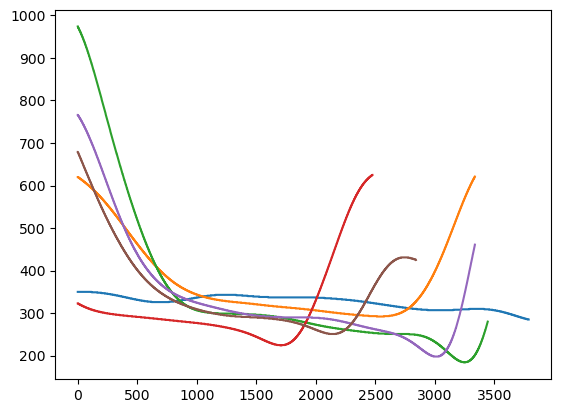

In [9]:
for tok in tokens.itertuples():
    rng = np.arange(match_tokentimes(tok.t1, ts), match_tokentimes(tok.t2, ts))
    plt.plot(nsfl[rng])
    # Call landmark-finding function here.